## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
# !echo {a}

In [3]:
sql_template = """
CREATE TEMP FUNCTION
    get_period_end() AS ((
        SELECT
        CAST(MAX(SAFE.PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%E*S', d.giftdate)) AS DATE),
        FROM `portal_model_scoring.training__account_1257_20210218` s, s.donations d));

    CREATE TEMP FUNCTION
        calculate_age(birthdate DATE) AS (
            DATE_DIFF(CURRENT_DATE, birthdate, YEAR) +
                (IF(EXTRACT(DAYOFYEAR FROM CURRENT_DATE) < EXTRACT(DAYOFYEAR FROM birthdate), -1, 0)));

        WITH
            constituents AS (
                SELECT
                candidate_id,
                calculate_age(SAFE.PARSE_DATE('%m/%d/%y', c.birthdate)) AS age,
                c.*
                FROM `portal_model_scoring.training__account_1257_20210218` s LEFT JOIN s.constituents c
                WHERE candidate_id IS NOT NULL
                ),

            donations AS (
                SELECT
                candidate_id,
                CASE
                WHEN d.giftamount IS NULL THEN 0.
                ELSE CAST(REGEXP_REPLACE(d.giftamount, r'[^a-zA-Z0-9]', '') AS INT64) / 100. END AS giftamount,  -- remove non-alphanumeric characters
                d.* EXCEPT(giftamount)
                FROM `portal_model_scoring.training__account_1257_20210218` s LEFT JOIN s.donations d
                WHERE candidate_id IS NOT NULL
                ),

            tickets AS (
                SELECT
                considpossiblymaybe,
                category_description,
                DATE(PARSE_TIMESTAMP("%m/%d/%Y %H:%M", expirydate)) AS expirydate,
                DATE(PARSE_TIMESTAMP("%m/%d/%Y %H:%M", membersince)) AS membersince,
                FROM `portal_model_scoring.training__account_1257_20210218` s LEFT JOIN s.tickets t
                WHERE membershipid IS NOT NULL
                ),

            zoo_pride AS (
                SELECT
                candidate_id,
                PARSE_DATE("%m/%d/%Y", mem_date_joined) AS mem_date_joined,
                DATE_ADD(PARSE_DATE("%m/%d/%Y", mem_date_joined), INTERVAL CAST(mem_total_years AS int64) YEAR) AS mem_date_end,
                memcurrent_expires_on,
                mem_standing,
                mem_total_years,
                mem_consecutive_years,
                mem_times_renewed,
                mem_category,
                mem_total_members,
                FROM `portal_model_scoring.training__account_1257_20210218` s LEFT JOIN s.zoo_pride z
                WHERE consid IS NOT NULL
                ),

            proposals AS (
                SELECT
                candidate_id,
                p.*
                FROM `portal_model_scoring.training__account_1257_20210218` s LEFT JOIN s.proposals p
                WHERE consid IS NOT NULL
                ),

            base AS ( -- list of gifts by candidate_id, date
                SELECT
                c.candidate_id,
                CAST(d.giftAmount AS float64) AS gift_amount,
                CAST(SAFE.PARSE_DATE('%m/%d/%Y', d.giftdate) AS DATE) AS transaction_date,
                FROM constituents c
                LEFT JOIN donations d ON c.candidate_id = d.candidate_id
                WHERE d.gifttype IN ("Cash", "Pledge", "Pay-Cash", "Stock/Property", "Recurring Gift", "Recurring Gift Pay-Cash")
            ),

            rolling_windows AS ( -- find every rolling 12 month period, sum amount of donations
                SELECT
                    candidate_id,
                    transaction_date,
                    gift_amount,
                    SUM(gift_amount) OVER(PARTITION BY candidate_id ORDER BY UNIX_SECONDS(TIMESTAMP(transaction_date)) RANGE BETWEEN 31104000 PRECEDING
                    AND CURRENT ROW -- 12 MONTHS * 30 DAYS/MONTH * 24HR/DAY * 3600SEC/HR = 171072000 SECONDS
                    ) AS rolling12mnth_amt,
                    COUNT(*) OVER(PARTITION BY candidate_id ORDER BY UNIX_SECONDS(TIMESTAMP(transaction_date)) RANGE BETWEEN 31104000 PRECEDING
                    AND CURRENT ROW -- 12 MONTHS * 30 DAYS/MONTH * 24HR/DAY * 3600SEC/HR = 171072000 SECONDS
                    ) AS rolling12mnth_ct
                FROM
                    base),

            -- TODO: this is a place where candidate_ids can be duplicated... it shouldn't be.
            ideals AS ( -- label ideals, set time period
                SELECT DISTINCT
                    candidate_id,
                    "ideal" AS label,
                    DATE_SUB(MAX(transaction_date), INTERVAL 12 MONTH) AS period_start,
                    MAX(transaction_date) AS period_end
                FROM rolling_windows
                WHERE rolling12mnth_amt >= 5000
                GROUP BY candidate_id),

            non_ideals AS ( -- non ideals are everyone else, time period is previous 60 months
                SELECT DISTINCT
                    base.candidate_id,
                    "non_ideal" AS label,
                    DATE_SUB(MAX(transaction_date), INTERVAL 12 MONTH) AS period_start,
                    MAX(transaction_date) AS period_end
                FROM base
                LEFT JOIN ideals ON base.candidate_id = ideals.candidate_id
                WHERE ideals.candidate_id IS NULL
                GROUP BY candidate_id),

            union_targets AS ( -- union
                SELECT *
                FROM non_ideals
                UNION DISTINCT
                SELECT *
                FROM ideals
                WHERE period_start >= '2010-01-01'),

            gift_features AS ( -- make some features
                SELECT
                DISTINCT
                t.candidate_id,
                period_start,
                period_end,
                label,
                ti.membersince AS ticket_member_since,
                ti.expirydate AS ticket_expiry_date,
                ti.category_description AS ticket_category_description,
                mem_date_joined AS zoo_pride_mem_date_joined,
                mem_date_end AS zoo_pride_mem_date_end,
                CASE WHEN ti.expirydate > period_end THEN DATE_DIFF(ti.expirydate, period_end, YEAR) ELSE NULL END AS ticket_member_years,
                CASE WHEN mem_date_end > period_end THEN memcurrent_expires_on ELSE NULL END AS zoo_pride_memcurrent_expires_on,
                CASE WHEN mem_date_end > period_end THEN mem_category ELSE NULL END AS zoo_pride_mem_category,
                CASE WHEN mem_date_end > period_end THEN mem_total_members ELSE NULL END AS zoo_pride_mem_total_members,
                CASE WHEN mem_date_end > period_end THEN DATE_DIFF(period_end, mem_date_joined, YEAR) ELSE NULL END AS zoo_pride_mem_total_years,
    --             -- TODO: prorate member total_years per period_end_date
    --             CASE WHEN mem_date_end > period_end THEN mem_consecutive_years ELSE NULL END AS zoo_pride_mem_consecutive_years,
    --             CASE WHEN mem_date_end > period_end THEN mem_standing ELSE NULL END AS zoo_pride_mem_standing,
    --             CASE WHEN mem_date_end > period_end THEN mem_times_renewed ELSE NULL END AS zoo_pride_mem_times_renewed,
                CASE
                    WHEN MAX(c.age) >= 18 THEN MAX(c.age) - DATE_DIFF(period_end, period_start, year) ELSE NULL END AS age_at_target_start,
                SUM(CASE
                    WHEN transaction_date >= period_start AND transaction_date <= period_end THEN gift_amount END) AS target_period_amt,
                SUM(CASE
                    WHEN transaction_date >= period_start AND transaction_date <= period_end THEN 1 END) AS target_period_ct,
                SUM(CASE
                    WHEN transaction_date < period_start AND transaction_date >= DATE_SUB(period_start, INTERVAL 24 month) THEN gift_amount END) AS two_yr_prior_amt,
                SUM(CASE
                    WHEN transaction_date < period_start AND transaction_date >= DATE_SUB(period_start, INTERVAL 24 month) THEN 1 END) AS two_yr_prior_ct,
                SUM(CASE
                    WHEN transaction_date < DATE_SUB(period_start, INTERVAL 24 month) AND transaction_date >= DATE_SUB(period_start, INTERVAL 60 month) THEN gift_amount END) AS five_yr_prior_amt,
                SUM(CASE
                    WHEN transaction_date < DATE_SUB(period_start, INTERVAL 24 month) AND transaction_date >= DATE_SUB(period_start, INTERVAL 60 month) THEN 1 END) AS five_yr_prior_ct,
                SUM(CASE
                    WHEN transaction_date < DATE_SUB(period_start, INTERVAL 60 month) THEN gift_amount END) AS historical_prior_amt,
                SUM(CASE
                    WHEN transaction_date < DATE_SUB(period_start, INTERVAL 60 month) THEN 1 END) AS historical_prior_ct,
                MAX(CASE
                    WHEN transaction_date < period_start THEN DATE_DIFF(period_start, transaction_date, month) END) AS donation_months_before_period_start,
                CASE
                WHEN expirydate < period_end
                THEN DATE_DIFF(expirydate, membersince, YEAR)
                ELSE DATE_DIFF(period_end, membersince, YEAR) END AS ticket_holder_years,
                CASE
                WHEN (expirydate IS NULL OR expirydate < period_end)
                THEN 0 ELSE 1 END AS is_ticket_holder,
                FROM
                union_targets t
                LEFT JOIN base b ON t.candidate_id = b.candidate_id
                LEFT JOIN constituents c ON t.candidate_id = c.candidate_id
                LEFT JOIN tickets ti ON t.candidate_id = ti.considpossiblymaybe
                LEFT JOIN zoo_pride z ON t.candidate_id = z.candidate_id
                GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
                ),

            matches AS (
                SELECT
                account_id,
                windfall_id ,
                candidate_id,
                confidence
                FROM `portal.match`
                WHERE account_id = 1257 AND confidence > 0.5
                ),

            distinct_constituents AS (
                SELECT DISTINCT
                m.windfall_id,
                t.*,
                g.* EXCEPT (candidate_id, period_start, period_end, label),
                ROW_NUMBER() OVER (PARTITION BY t.candidate_id ORDER BY target_period_amt DESC) AS rn
                FROM union_targets t
                LEFT JOIN gift_features g ON t.candidate_id = g.candidate_id
                AND g.period_start = t.period_start
                AND g.period_end = t.period_end
                AND g.label = t.label
                LEFT JOIN matches m ON t.candidate_id = m.candidate_id)

            SELECT
            * EXCEPT(rn)
            FROM distinct_constituents c
            LEFT JOIN `tranquil-garage-139216.people.audience_latest` audience ON audience.id = c.windfall_id
            WHERE rn = 1
"""

In [4]:
import pandas as pd

df = pd.read_csv("data/hnp_stats_csv/HNP_StatsData.csv")
df = pd.melt(df, id_vars=["Indicator Name", "Country Name"])
df.head()

,Indicator Name,Country Name,variable,value
0,"Adolescent fertility rate (births per 1,000 wo...",Arab World,Country Code,ARB
1,Adults (ages 15+) and children (0-14 years) li...,Arab World,Country Code,ARB
2,Adults (ages 15+) and children (ages 0-14) new...,Arab World,Country Code,ARB
3,Adults (ages 15+) living with HIV,Arab World,Country Code,ARB
4,Adults (ages 15-49) newly infected with HIV,Arab World,Country Code,ARB


In [5]:
df["variable"].unique()

array(['Country Code', 'Indicator Code', '1960', '1961', '1962', '1963',
       '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', 'Unnamed: 65'], dtype=object)

In [6]:
years = [str(s) for s in range(1989, 2020)]

In [7]:
df = df[[x in years for x in df["variable"]]]
df.head()

,Indicator Name,Country Name,variable,value
3436412,"Adolescent fertility rate (births per 1,000 wo...",Arab World,1989,72.8194
3436413,Adults (ages 15+) and children (0-14 years) li...,Arab World,1989,NaN
3436414,Adults (ages 15+) and children (ages 0-14) new...,Arab World,1989,NaN
3436415,Adults (ages 15+) living with HIV,Arab World,1989,NaN
3436416,Adults (ages 15-49) newly infected with HIV,Arab World,1989,NaN


In [8]:
df = df.fillna(0).pivot_table(values="value", 
                         index=["Country Name", "variable"],
                         columns="Indicator Name", 
                         aggfunc="mean").reset_index()

In [9]:
import pandas as pd

# DOWNLOAD DATSET HERE: https://www.kaggle.com/kaushiksuresh147/customer-segmentation
# df = pd.read_csv("data/segmentation_train.csv")

print(df.shape)
df.head()

(8029, 430)


Indicator Name,Country Name,variable,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,"Age at first marriage, female",...,Urban population (% of total population),Urban population growth (annual %),Urban poverty headcount ratio at national poverty lines (% of urban population),Use of insecticide-treated bed nets (% of under-5 population),Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,1989,0.0,0.0,162.2886,0.0,0.0,0.0,0.0,0.0,...,21.088,2.564047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,1990,100.0,0.0,162.8354,500.0,100.0,500.0,100.0,0.0,...,21.177,4.898023,0.0,0.0,0.0,0.0,0.0,0.0,24.2,100.0
2,Afghanistan,1991,100.0,0.0,163.3822,500.0,100.0,500.0,100.0,0.0,...,21.266,7.319562,0.0,0.0,0.0,0.0,0.0,0.0,24.4,100.0
3,Afghanistan,1992,100.0,0.0,163.9290,500.0,100.0,500.0,100.0,0.0,...,21.355,8.963742,0.0,0.0,0.0,0.0,0.0,0.0,24.5,100.0
4,Afghanistan,1993,100.0,0.0,164.1888,1000.0,200.0,1000.0,100.0,0.0,...,21.444,9.206788,0.0,0.0,0.0,0.0,0.0,0.0,25.0,100.0


In [10]:
df["Country Name"].value_counts()

Rwanda                         31
Liechtenstein                  31
Jordan                         31
Maldives                       31
Equatorial Guinea              31
                               ..
Mali                           31
United Kingdom                 31
Macao SAR, China               31
Pacific island small states    31
Romania                        31
Name: Country Name, Length: 259, dtype: int64

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.10,
    stratify=df["Country Name"])

df_train.shape, df_test.shape
df = df_train.copy()

# shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["Country Name"]
y_block = CategoryBlock()

exclude_vars = ["id", "variable", "Indicator Name", "Country Name"]

In [13]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{}

In [14]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['AIDS estimated deaths (UNAIDS estimates)',
 'ARI treatment (% of children under 5 taken to a health provider)',
 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Adults (ages 15+) and children (0-14 years) living with HIV',
 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
 'Adults (ages 15+) living with HIV',
 'Adults (ages 15-49) newly infected with HIV',
 'Age at first marriage, female',
 'Age at first marriage, male',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old',
 'Age dependency ratio, young',
 'Age population, age 00, female, interpolated',
 'Age population, age 00, male, interpolated',
 'Age population, age 01, female, interpolated',
 'Age population, age 01, male, interpolated',
 'Age population, age 02, female, interpolated',
 'Age population, age 02, male, interpolated',
 'Age population, age 03, female, interpolated',
 'Age population, age 03, male, interpolated',
 'Age population, age 04, female

In [15]:
# df

In [16]:
# import seaborn as sns

# sns.pairplot(df[["AIDS estimated deaths (UNAIDS estimates)", 
#                  "Age at first marriage, female", 
#                  "Number of people who are undernourished", 
#                  "Country Name"]].sample(frac=0.05), hue='Country Name', palette="tab10")

In [17]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [18]:
# train_ds.tabular_pandas["num_cars"]

In [19]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter, TrainTestSplitter

splits = TrainTestSplitter(test_size=0.20, 
                           train_size=0.80, 
                           random_state=None, 
                           stratify=df["Country Name"].values, 
                           shuffle=True)(range_of(df))

In [20]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [21]:
# from mobius.samplers import ImbalancedDatasetSampler

trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=32,
    shuffle=True,
    drop_last=True,)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=32,)

In [22]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

# print("Sample batch:")
# dls.one_batch()

In [23]:
import torch
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [512, 128, 32]

# tabular learner configuration
config = tabular_config(ps=[0.05, 0.05, 0.05], embed_p=0.03, act_cls=torch.nn.Tanh())

# create tabular learner
#
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [24]:
learn.fit_one_cycle(n_epoch=10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,5.251588,5.111979,0.094744,0.060799,0.096268,0.056900,00:02
1,4.655641,4.393174,0.212310,0.183346,0.216988,0.158229,00:02
2,3.874005,3.608979,0.349239,0.354041,0.352896,0.301174,00:02
3,3.234865,3.077402,0.457815,0.471073,0.464093,0.412484,00:02
4,2.777983,2.625336,0.577455,0.591186,0.583269,0.534256,00:02
5,2.440757,2.284756,0.654910,0.675225,0.658559,0.624201,00:02
6,2.247895,2.110973,0.668741,0.695759,0.672072,0.641780,00:02
7,2.072633,1.937340,0.733057,0.745428,0.735135,0.706421,00:02
8,1.998177,1.893742,0.730290,0.740177,0.732947,0.703618,00:02
9,1.989970,1.995661,0.714384,0.728666,0.717761,0.688331,00:02


/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/s

In [25]:
# learn.export("tabular_learn_wine.pkl")

In [26]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 1.996, ECE: 0.532
Optimal temperature: 0.113
After temperature - NLL: 1.334, ECE: 0.143


In [27]:
# true species labels
y_true=learn.dls.valid.items["Country Name"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(10, 10),
 (153, 180),
 (182, 182),
 (38, 88),
 (208, 188),
 (173, 173),
 (80, 80),
 (45, 45),
 (160, 160),
 (83, 83)]

In [29]:
(y_true == preds).sum() / len(y_true)

0.7143845089903181

In [30]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [31]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [32]:
train_ds.__getitem__(10)

((tensor([], dtype=torch.int64),
  tensor([-0.1041, -0.2502, -0.7056, -0.1068, -0.1091, -0.1051, -0.1074, -0.4648,
          -0.4319, -0.4203,  1.4807, -0.8153, -0.2457, -0.2375, -0.2449, -0.2365,
          -0.2433, -0.2349, -0.2424, -0.2340, -0.2411, -0.2328, -0.2402, -0.2319,
          -0.2393, -0.2311, -0.2385, -0.2303, -0.2377, -0.2296, -0.2369, -0.2289,
          -0.2358, -0.2280, -0.2347, -0.2270, -0.2335, -0.2259, -0.2323, -0.2249,
          -0.2311, -0.2239, -0.2300, -0.2229, -0.2288, -0.2218, -0.2276, -0.2207,
          -0.2264, -0.2196, -0.2251, -0.2184, -0.2235, -0.2169, -0.2215, -0.2151,
          -0.2197, -0.2134, -0.2182, -0.2121, -0.2171, -0.2110, -0.2162, -0.2102,
          -0.4537, -0.4170, -0.7623, -0.7080, -0.3349, -0.2617, -0.3099, -0.3378,
          -0.1110, -0.1088, -0.1028, -0.1605, -0.1121, -0.2664, -0.1739, -0.1740,
          -0.1965, -0.2050, -0.2882, -0.1968, -0.1672, -0.1821, -0.1547, -0.1438,
          -0.1465, -0.1164, -0.1297, -0.2063, -0.3933, -0.3577,  

In [33]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [34]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [35]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=16,  # size of output space
    bn=True,
    act=None)

In [36]:
# TODO: add custom fast.ai callback
import time
import torch
import pandas as pd
from fastai.callback.core import Callback
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: save every TSNE model as pkl - interactive 3-d w/ tooltip to show point information (id, features, etc.)
class TSNECallback(Callback):
    def after_validate(self):
        plt.clf()
        t = int(time.time())
        train_encoded = list()
        for i in range(len(self.dls.valid_ds.tabular_pandas)):
            p, _, _ = self.dls.valid_ds.get_items(i, 0)

            # rehsape into mini-batch size 1
            p = p[0].reshape(1, -1), p[1].reshape(1, -1)

            # encode the household into output embedding space
            p_encode = siamese_learner.model.encode(p)
            train_encoded.append(p_encode)
            
        ids = self.dls.valid.get_idxs()
        y_train_labels = self.dls.valid.tabular_pandas["Country Name"]
        train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())
        # write encoded space to csv
        train_encoded_df.to_csv(f"tsne_{t}_{self.epoch}.csv")
        
        # limit the permutation of hyper-params of t-SNE
        tsne = TSNE(n_components=2, metric="euclidean", n_iter=500)
        encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)
        np.save(f"tsne_{t}_{self.epoch}.npy", encoded_train_tsne)
        
        # TODO: add title...
        sns.scatterplot(x=encoded_train_tsne[:,0],
                        y=encoded_train_tsne[:,1],
                        hue=y_train_labels, 
#                         legend='full', 
                        palette="tab10").figure.savefig(f"snn_{t}_epoch_{self.epoch}.png")
        
        
# TODO: run knn on embedding space to show learned embedding is informative!!!

In [37]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [38]:
# TODO: run grid search over margin... how do we find and start with intelligent margins?
# ... instead of relying on brute force searching?

# def fit_siamese_learner(margin=0.10)

In [39]:
# TODO: reverse the pre-trained operation to learn a SNN and load the pre-trained weights into TabularLearner

In [40]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.5)(out, targ.long())

In [41]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter,
    cbs=[TSNECallback])

In [42]:
# # %debug
# siamese_learner.unfreeze()
# siamese_learner.fit_one_cycle(n_epoch=20)

In [43]:
y_labels = siamese_learner.dls.valid.tabular_pandas["Country Name"]
y_labels.to_csv("y_labels.csv")

epoch,train_loss,valid_loss,time
0,62.566521,56.087608,18:47
1,49.465046,39.613369,19:10
2,35.376915,29.505487,19:09
3,27.925669,25.229885,19:06
4,19.454300,16.742016,19:05
5,14.861103,13.790450,18:51
6,11.667397,10.616087,18:58
7,10.441314,8.633843,18:59
8,7.995676,7.091744,18:49
9,6.741169,5.200465,19:04


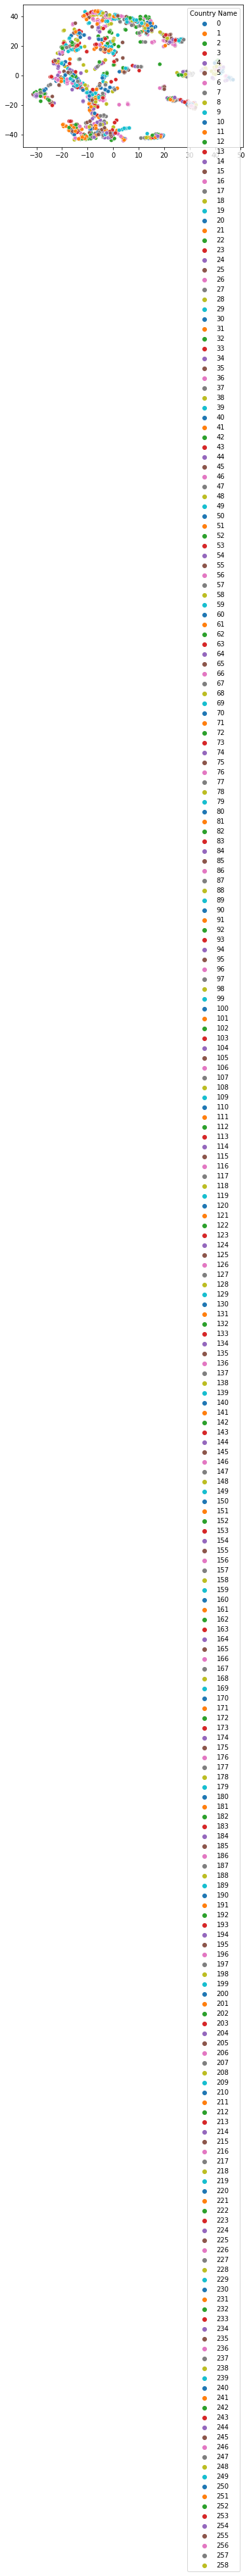

In [44]:
# siamese_learner.unfreeze()

# lr_min, _ = siamese_learner.lr_find()
siamese_learner.fit(n_epoch=10, lr=1e-4)

In [45]:
# siamese_learner.unfreeze()

# lr_min, _ = siamese_learner.lr_find()
# siamese_learner.fit(n_epoch=3, lr=lr_min)

In [46]:
# original_points = list()
# for i in range(len(valid_ds)):
#     p, _, _ = valid_ds.get_items(i=i, j=0)
#     original_points.append(pd.Series(np.concatenate([p[0].numpy(), p[1].numpy()])))

In [47]:
t0 = pd.DataFrame(original_points)
# t0 = pd.concat([y_labels.reset_index(drop=True), t0], ignore_index=False, axis=1)
t0.head()

NameError: name 'original_points' is not defined

In [ ]:
t4 = pd.read_csv("tsne_1618741679_4.csv").drop("Unnamed: 0", axis=1)
# t4 = pd.concat([y_labels.reset_index(drop=True), t4], ignore_index=False, axis=1)
t4.head()

In [ ]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(t0, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 4)

# Fit the classifier to the data
knn.fit(X_train, y_train)

In [ ]:
#show first 5 model predictions on the test data
knn.predict(X_test)[0:5]

In [ ]:
#check accuracy of our model on the test data
knn.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

pr, re, fs, _ = precision_recall_fscore_support(y_test, knn.predict(X_test))
print(confusion_matrix(y_test, knn.predict(X_test)))
f"precision: {pr[1]}, recall: {re[1]}, fscore: {fs[1]}"

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

In [ ]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X_train, y_train)

In [ ]:
#check top performing n_neighbors value
knn_gscv.best_params_

In [ ]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

In [ ]:
np.load("tsne_1618681529_0.npy")